### Importações

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

### Carregar dados

In [79]:
df = pd.read_parquet('./Base/base_pronta_2023 2025.03.03.parquet')

In [80]:
df.drop(columns=['pib_nominal', 'alunos_escola', 'quantidade_total_vagas', 'RCL'], inplace=True)

In [81]:
df.columns

Index(['ano_exercicio', 'cd_municipio_ibge', 'ds_municipio', 'cod_subelemento',
       'vl_despesa', 'pop_total', 'atividade_principal', 'vereadores', 'area',
       'Agropecuária', 'Indústria', 'Administração Pública',
       'Total  (exclusive Administração Pública)', 'Total geral', 'Impostos',
       'PIB (1)', 'PIB per Capita (2)', 'Efetivo', 'Efetivo em Comissão',
       'Exclusivamente em Comissão', 'QT_MAT_BAS', 'QT_MAT_INF', 'QT_MAT_FUND',
       'QT_DOC_BAS', 'QT_DOC_INF', 'QT_DOC_FUND', 'receitas_correntes',
       'receitas_capital', 'receita_total', 'leitos_total', 'leitos_hab',
       'leitos sus', 'leitos_sus_hab', 'leitos não sus', 'leitos_naosus_hab'],
      dtype='object')

In [82]:
df.isna().any()

ano_exercicio                               False
cd_municipio_ibge                           False
ds_municipio                                False
cod_subelemento                             False
vl_despesa                                  False
pop_total                                   False
atividade_principal                         False
vereadores                                  False
area                                        False
Agropecuária                                False
Indústria                                   False
Administração Pública                       False
Total  (exclusive Administração Pública)    False
Total geral                                 False
Impostos                                    False
PIB (1)                                     False
PIB per Capita (2)                          False
Efetivo                                      True
Efetivo em Comissão                          True
Exclusivamente em Comissão                   True


### Primeiro teste - 2010 a 2023 usando dados que estão presentes todos os exercícios

In [83]:
# Separar os dados de treino (2010-2022) e teste (2023)
df_train = df[df['ano_exercicio'] <= 2022].drop(columns=['cd_municipio_ibge', 'ds_municipio', 
                                                         'Efetivo', 'Efetivo em Comissão', 'Exclusivamente em Comissão']).copy()
df_test = df[df['ano_exercicio'] == 2023].drop(columns=['ds_municipio', 'Efetivo', 'Efetivo em Comissão', 'Exclusivamente em Comissão']).copy()

In [84]:
# Codificação das variáveis categóricas
encoder_sub = LabelEncoder()
encoder_atividade = LabelEncoder()

df_train['cod_subelemento'] = encoder_sub.fit_transform(df_train['cod_subelemento'])
df_train['atividade_principal'] = encoder_atividade.fit_transform(df_train['atividade_principal'])

df_test['cod_subelemento'] = encoder_sub.transform(df_test['cod_subelemento'])
df_test['atividade_principal'] = encoder_atividade.transform(df_test['atividade_principal'])

In [85]:
# Definir variáveis preditoras e alvo
X_train = df_train.drop(columns=['ano_exercicio', 'vl_despesa'])
y_train = df_train['vl_despesa']

X_test = df_test  # Vamos prever `vl_despesa` para esse conjunto

In [86]:
# Lista de colunas numéricas
cols_num = ['pop_total', 'vereadores', 'area', 'Agropecuária', 'Indústria',
            'Administração Pública', 'Total  (exclusive Administração Pública)',
            'Total geral', 'Impostos', 'PIB (1)', 'PIB per Capita (2)',
            'QT_MAT_BAS', 'QT_MAT_INF', 'QT_MAT_FUND', 'QT_DOC_BAS', 'QT_DOC_INF',
            'QT_DOC_FUND', 'receitas_correntes', 'receitas_capital', 'receita_total',
            'leitos_total', 'leitos_hab', 'leitos sus', 'leitos_sus_hab', 'leitos não sus', 'leitos_naosus_hab']

# Inicializar o StandardScaler
scaler = StandardScaler()

# Criar cópias dos datasets para evitar modificar os originais
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Aplicar a normalização apenas nas colunas numéricas
X_train_scaled[cols_num] = scaler.fit_transform(X_train[cols_num])
X_test_scaled[cols_num] = scaler.transform(X_test[cols_num])

In [87]:
# Modelos
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_lgbm = LGBMRegressor(n_estimators=100, random_state=42)
model_svm = SVR(kernel='rbf')

In [88]:
model_rf.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [89]:
model_lgbm.fit(X_train_scaled, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6121
[LightGBM] [Info] Number of data points in the train set: 435949, number of used features: 28
[LightGBM] [Info] Start training from score 3721033.424980


LGBMRegressor(random_state=42)

In [90]:
model_svm.fit(X_train_scaled, y_train)

SVR()

In [91]:
X_test_scaled.head()

,ano_exercicio,cd_municipio_ibge,cod_subelemento,vl_despesa,pop_total,atividade_principal,vereadores,area,Agropecuária,Indústria,...,QT_DOC_FUND,receitas_correntes,receitas_capital,receita_total,leitos_total,leitos_hab,leitos sus,leitos_sus_hab,leitos não sus,leitos_naosus_hab
435949,2023,3500105,0,2.980216e+06,-0.175989,3,-0.573849,0.060482,-0.081299,-0.242015,...,-0.380334,-0.126209,-0.103574,-0.127008,0.260443,1.659307,0.349935,1.573287,0.104342,1.095776
435950,2023,3500105,1,2.637137e+06,-0.175989,3,-0.573849,0.060482,-0.081299,-0.242015,...,-0.380334,-0.126209,-0.103574,-0.127008,0.260443,1.659307,0.349935,1.573287,0.104342,1.095776
435951,2023,3500105,2,7.540573e+05,-0.175989,3,-0.573849,0.060482,-0.081299,-0.242015,...,-0.380334,-0.126209,-0.103574,-0.127008,0.260443,1.659307,0.349935,1.573287,0.104342,1.095776
435952,2023,3500105,4,3.304972e+07,-0.175989,3,-0.573849,0.060482,-0.081299,-0.242015,...,-0.380334,-0.126209,-0.103574,-0.127008,0.260443,1.659307,0.349935,1.573287,0.104342,1.095776
435953,2023,3500105,7,2.761197e+06,-0.175989,3,-0.573849,0.060482,-0.081299,-0.242015,...,-0.380334,-0.126209,-0.103574,-0.127008,0.260443,1.659307,0.349935,1.573287,0.104342,1.095776


In [92]:
# Previsão para 2023
df_test['vl_despesa_pred_rf'] = model_rf.predict(X_test_scaled.drop(columns=['ano_exercicio', 'cd_municipio_ibge', 'vl_despesa']))
df_test['vl_despesa_pred_lgbm'] = model_lgbm.predict(X_test_scaled.drop(columns=['ano_exercicio', 'cd_municipio_ibge', 'vl_despesa']))
df_test['vl_despesa_pred_svm'] = model_svm.predict(X_test_scaled.drop(columns=['ano_exercicio', 'cd_municipio_ibge', 'vl_despesa']))

from datetime import datetime

# Obter a data atual no formato AAAA.MM.DD
hoje = datetime.today().strftime('%Y.%m.%d')

# Exportar resultados
df_test[['cod_subelemento', 'vl_despesa_pred_rf', 'vl_despesa_pred_lgbm', 'vl_despesa_pred_svm']].to_csv(f'previsao_2023 {hoje}.csv', index=False)

print("Previsões para 2023 salvas em 'previsao_2023.csv'.")

Previsões para 2023 salvas em 'previsao_2023.csv'.


### Avaliação dos Modelos

In [93]:
# Separação treino/validação dentro dos dados de 2010-2022
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# Treinamento novamente nos dados reduzidos
model_rf.fit(X_train_split, y_train_split)
model_lgbm.fit(X_train_split, y_train_split)
model_svm.fit(X_train_split, y_train_split)

# Previsões na validação
y_pred_rf = model_rf.predict(X_val)
y_pred_lgbm = model_lgbm.predict(X_val)
y_pred_svm = model_svm.predict(X_val)

# Função de avaliação
def avaliar_modelo(y_true, y_pred, nome_modelo):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f'{nome_modelo} - MAE: {mae:.2f}, MSE: {mse:.2f}, R²: {r2:.2f}')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6121
[LightGBM] [Info] Number of data points in the train set: 348759, number of used features: 28
[LightGBM] [Info] Start training from score 3731643.446356


In [94]:
# Avaliação dos três modelos
avaliar_modelo(y_val, y_pred_rf, 'Random Forest')
avaliar_modelo(y_val, y_pred_lgbm, 'LightGBM')
avaliar_modelo(y_val, y_pred_svm, 'SVM')

Random Forest - MAE: 1442655.41, MSE: 87595618109035.50, R²: 0.85
LightGBM - MAE: 2240732.96, MSE: 114995967684937.88, R²: 0.81
SVM - MAE: 3575407.74, MSE: 611587484664399.00, R²: -0.02


In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# Definir os parâmetros para busca do Random Forest
param_grid_rf = {
    'n_estimators': [100, 300, 500], 
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4]
}

# Definir os parâmetros para busca do LightGBM
param_grid_lgbm = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, -1]  # -1 significa sem limite de profundidade
}

# Criar os modelos base
rf = RandomForestRegressor(random_state=42)
lgbm = LGBMRegressor(random_state=42)

# Aplicar GridSearchCV no Random Forest
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_rf.fit(X_train_scaled, y_train)

# Aplicar GridSearchCV no LightGBM
grid_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid_lgbm, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
grid_lgbm.fit(X_train_scaled, y_train)

# Exibir os melhores hiperparâmetros
print("Melhores parâmetros para Random Forest:", grid_rf.best_params_)
print("Melhores parâmetros para LightGBM:", grid_lgbm.best_params_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Users\fmacieira\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
7 fits failed out of a total of 243.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\fmacieira\AppData\Local\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\fmacieira\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\fmacieira\AppData\Local\anaconda3\Lib\site-packag

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6121
[LightGBM] [Info] Number of data points in the train set: 435949, number of used features: 28
[LightGBM] [Info] Start training from score 3721033.424980
Melhores parâmetros para Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Melhores parâmetros para LightGBM: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 100}


In [96]:
# Treinar Random Forest com os melhores parâmetros
best_rf = RandomForestRegressor(**grid_rf.best_params_, random_state=42)
best_rf.fit(X_train_scaled, y_train)

# Treinar LightGBM com os melhores parâmetros
best_lgbm = LGBMRegressor(**grid_lgbm.best_params_, random_state=42)
best_lgbm.fit(X_train_scaled, y_train)

# Fazer previsões e avaliar novamente
y_pred_rf_best = best_rf.predict(X_val)
y_pred_lgbm_best = best_lgbm.predict(X_val)

avaliar_modelo(y_val, y_pred_rf_best, 'Random Forest Otimizado')
avaliar_modelo(y_val, y_pred_lgbm_best, 'LightGBM Otimizado')

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6121
[LightGBM] [Info] Number of data points in the train set: 435949, number of used features: 28
[LightGBM] [Info] Start training from score 3721033.424980
Random Forest Otimizado - MAE: 491934.75, MSE: 10948540575936.83, R²: 0.98
LightGBM Otimizado - MAE: 1298927.03, MSE: 21374326746859.20, R²: 0.96


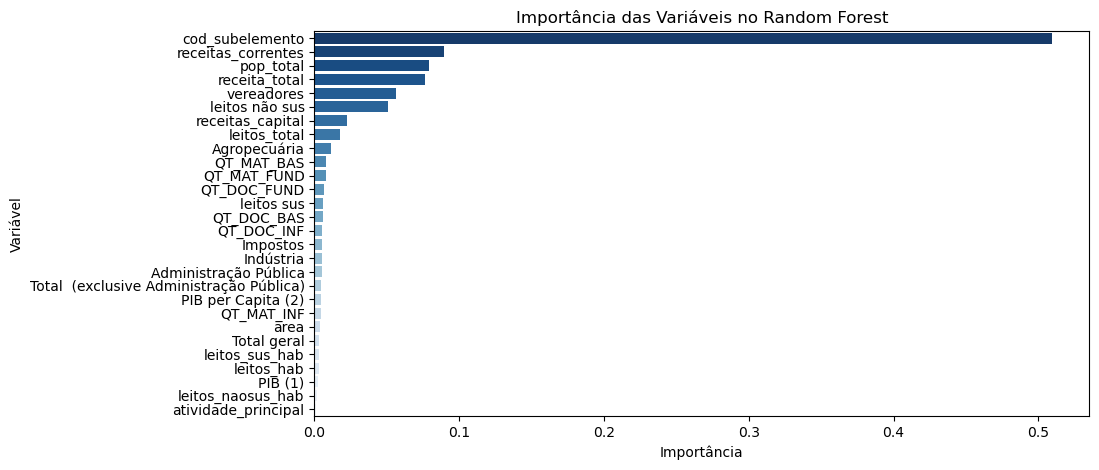

In [ ]:
# Obter a importância das variáveis no modelo treinado
importances = best_rf.feature_importances_

# Criar um DataFrame com os nomes das variáveis e suas importâncias
feature_importance_df = pd.DataFrame({'Variável': X_train.columns, 'Importância': importances})

# Ordenar da mais importante para a menos importante
feature_importance_df = feature_importance_df.sort_values(by='Importância', ascending=False)

# Plotar um gráfico de barras
plt.figure(figsize=(10, 5))
sns.barplot(x='Importância', y='Variável', data=feature_importance_df, palette='Blues_r', hue='Variável', legend=False)
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis no Random Forest')
plt.show()


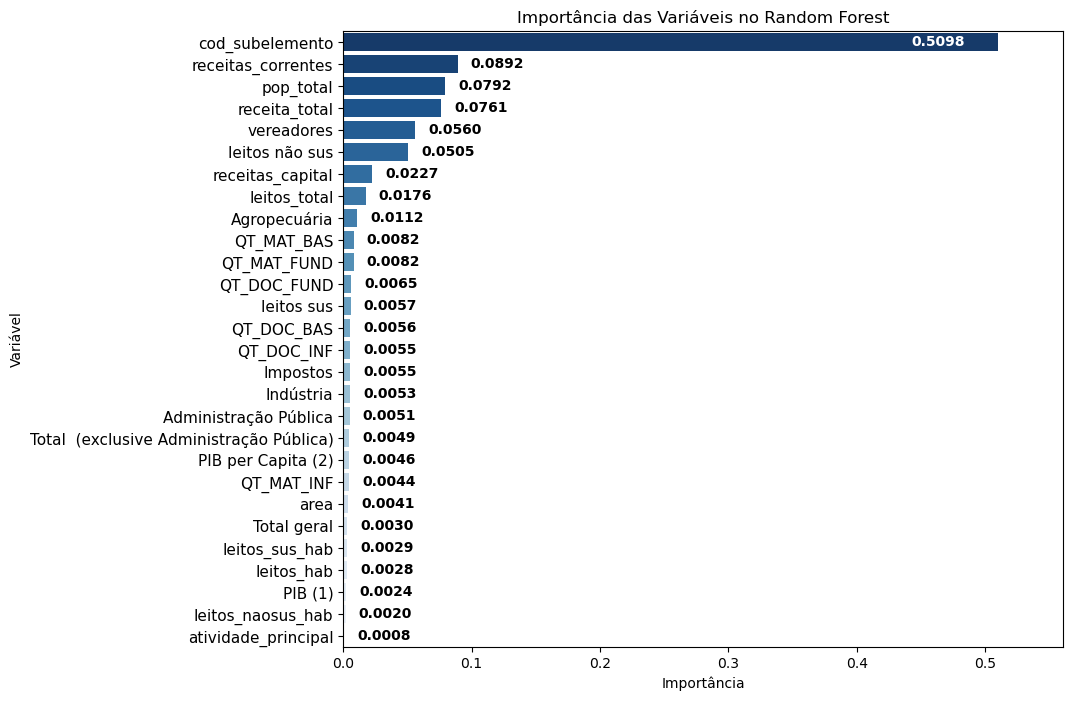

In [101]:
# Obter a importância das variáveis no modelo treinado
importances = best_rf.feature_importances_

# Criar um DataFrame com os nomes das variáveis e suas importâncias
feature_importance_df = pd.DataFrame({'Variável': X_train.columns, 'Importância': importances})

# Ordenar da mais importante para a menos importante
feature_importance_df = feature_importance_df.sort_values(by='Importância', ascending=False)

# Criar o gráfico
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Importância', y='Variável', data=feature_importance_df, palette='Blues_r', hue='Variável', legend=False)

# Definir o limite do eixo X para dar espaço aos valores
max_value = feature_importance_df['Importância'].max()
plt.xlim(0, max_value * 1.1)  # Adicionar 10% de margem para evitar corte

# Adicionar os valores nas barras com lógica adaptada
for i, (valor, var) in enumerate(zip(feature_importance_df['Importância'], feature_importance_df['Variável'])):
    if valor > max_value * 0.3:  # Se a barra for grande, colocar o texto dentro (branco)
        ax.text(valor * 0.95, i, f'{valor:.4f}', 
                va='center', ha='right', fontsize=10, fontweight='bold', color='white')
    else:  # Se a barra for pequena, manter o texto fora (preto)
        ax.text(valor + (max_value * 0.02), i, f'{valor:.4f}', 
                va='center', fontsize=10, fontweight='bold', color='black')

# Ajustar espaçamento entre os rótulos do eixo Y
plt.xticks(rotation=0)
plt.yticks(fontsize=11)  # Fonte maior para os rótulos do eixo Y
plt.subplots_adjust(left=0.3)  # Mais espaço no lado esquerdo para os rótulos

# Definir rótulos e título
plt.xlabel('Importância')
plt.ylabel('Variável')
plt.title('Importância das Variáveis no Random Forest')

# Exibir o gráfico
plt.show()